/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Distribución de clases antes del balanceo:
custcat
3    0.2825
1    0.2575
4    0.2375
2    0.2225
Name: proportion, dtype: float64


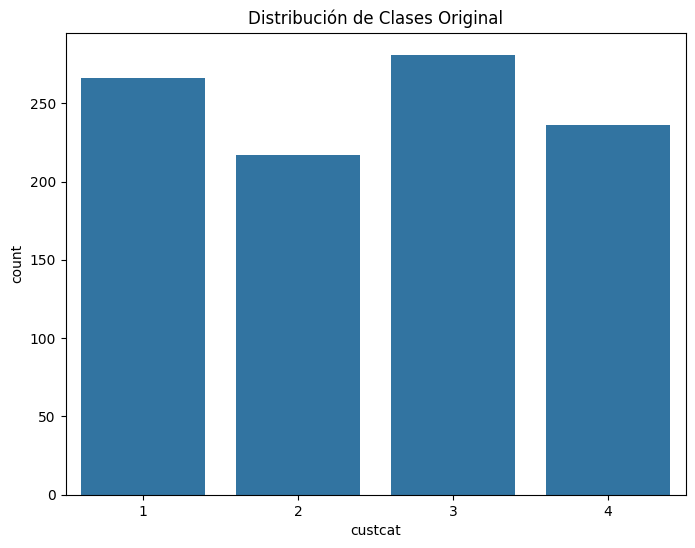

[I 2024-11-29 09:01:10,827] A new study created in memory with name: no-name-3b1dd4cc-26ed-4e88-931d-e739e21a1f68
[I 2024-11-29 09:01:19,335] Trial 0 finished with value: 0.36124999999999996 and parameters: {'n_estimators': 182, 'max_depth': 10, 'learning_rate': 0.021908203282459307, 'subsample': 0.9654110049651516, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.36124999999999996.
[I 2024-11-29 09:01:23,195] Trial 1 finished with value: 0.36875 and parameters: {'n_estimators': 93, 'max_depth': 10, 'learning_rate': 0.1601587532183866, 'subsample': 0.8674021115282688, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.36875.
[I 2024-11-29 09:01:25,771] Trial 2 finished with value: 0.38125 and parameters: {'n_estimators': 136, 'max_depth': 5, 'learning_rate': 0.024621226380645476, 'subsample': 0.8094896658575134, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.38125.
[I 2024-11-29 09:01:28,848] Trial 3


Mejores parámetros encontrados: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.0259080015432796, 'subsample': 0.6644220273337567, 'min_samples_split': 10, 'min_samples_leaf': 5}

Métricas del modelo final:

Accuracy en entrenamiento: 0.89125
Accuracy en test: 0.37

Reporte de clasificación en test:
              precision    recall  f1-score   support

           1       0.44      0.42      0.43        60
           2       0.28      0.28      0.28        39
           3       0.40      0.42      0.41        55
           4       0.33      0.33      0.33        46

    accuracy                           0.37       200
   macro avg       0.36      0.36      0.36       200
weighted avg       0.37      0.37      0.37       200



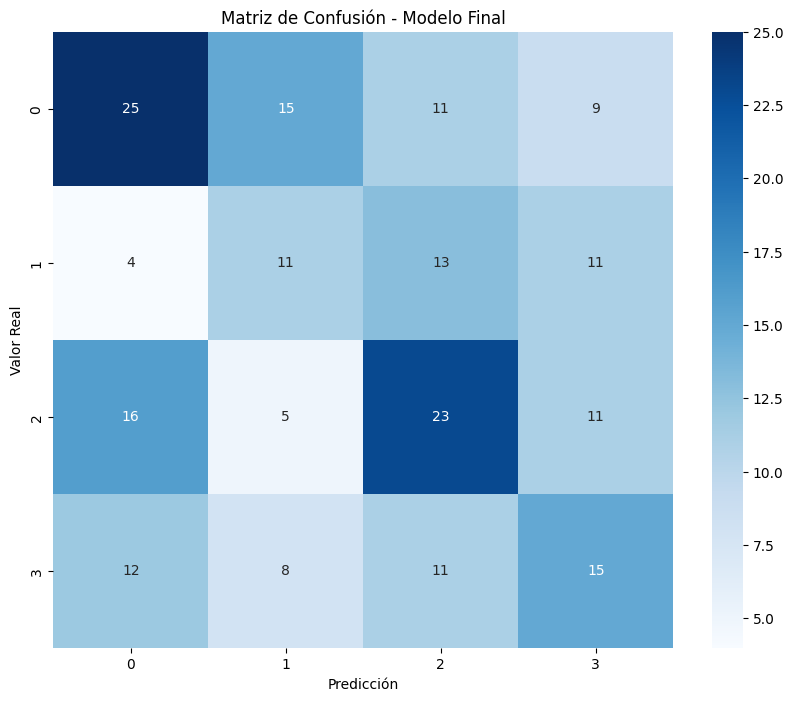

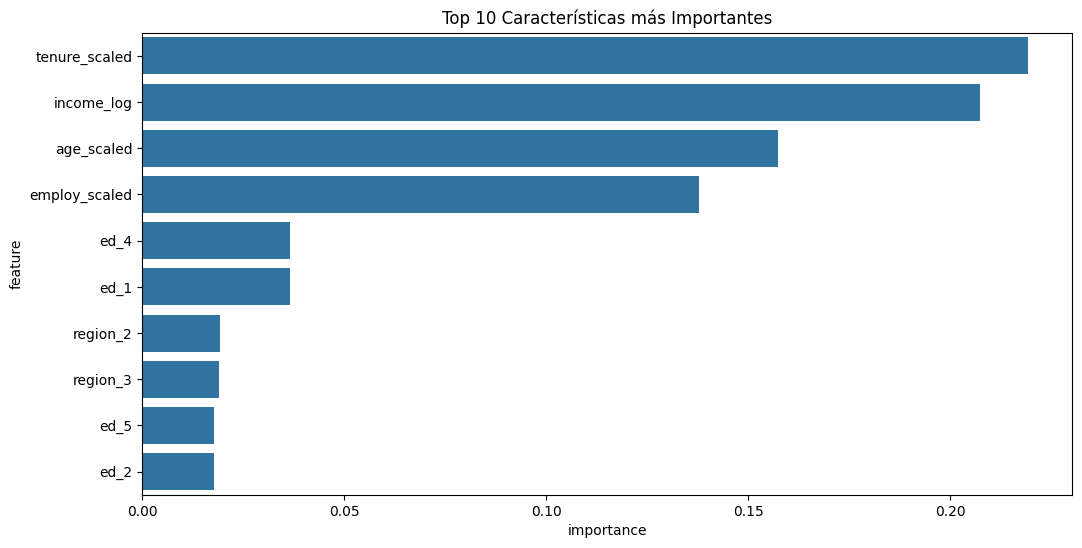

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Cargar datos
df = pd.read_csv('telecust1000_transformed.csv')

# Preparar datos
features = ['income_log', 'age_scaled', 'tenure_scaled', 'employ_scaled', 
           'retire_scaled', 'region', 'marital', 'ed', 'gender', 'reside']

X = df[features]
y = df['custcat']

# Convertir variables categóricas
X = pd.get_dummies(X, columns=['region', 'marital', 'ed', 'gender', 'reside'])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Analizar desbalanceo de clases
print("Distribución de clases antes del balanceo:")
print(y_train.value_counts(normalize=True))

# Visualizar distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='custcat')
plt.title('Distribución de Clases Original')
plt.show()

# Función objetivo para Optuna (Gradient Boosting)
def objective(trial):
    # Parámetros para optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
    }
    
    # Crear pipeline con SMOTE y GradientBoosting
    model = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', GradientBoostingClassifier(**params, random_state=42))
    ])
    
    # Evaluar usando validación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

# Ejecutar optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Obtener mejores parámetros
best_params = study.best_params
print("\nMejores parámetros encontrados:", best_params)

# Crear y entrenar modelo final con los mejores parámetros
final_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(**best_params, random_state=42))
])

final_model.fit(X_train, y_train)

# Evaluar modelo
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Imprimir métricas
print("\nMétricas del modelo final:")
print("\nAccuracy en entrenamiento:", accuracy_score(y_train, y_pred_train))
print("Accuracy en test:", accuracy_score(y_test, y_pred_test))
print("\nReporte de clasificación en test:")
print(classification_report(y_test, y_pred_test))

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo Final')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Visualizar importancia de características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.named_steps['classifier'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Características más Importantes')
plt.show()

# Guardar el modelo final
model_data = {
    'model': final_model,
    'feature_columns': list(X.columns),
    'best_params': best_params,
    'metrics': {
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test)
    }
}

joblib.dump(model_data, 'advanced_model.joblib')

# Guardar resumen en archivo de texto
with open('advanced_model_summary.txt', 'w') as f:
    f.write("RESUMEN DEL MODELO AVANZADO\n")
    f.write("===========================\n\n")
    f.write("Mejores parámetros encontrados:\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    
    f.write("\nMétricas de rendimiento:\n")
    f.write(f"Accuracy en entrenamiento: {accuracy_score(y_train, y_pred_train):.4f}\n")
    f.write(f"Accuracy en test: {accuracy_score(y_test, y_pred_test):.4f}\n")
    
    f.write("\nReporte de clasificación:\n")
    f.write(classification_report(y_test, y_pred_test))

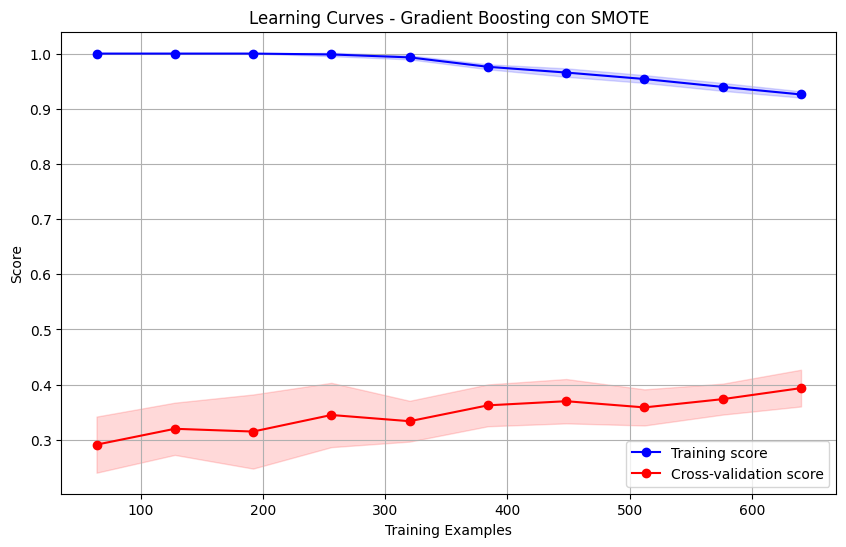

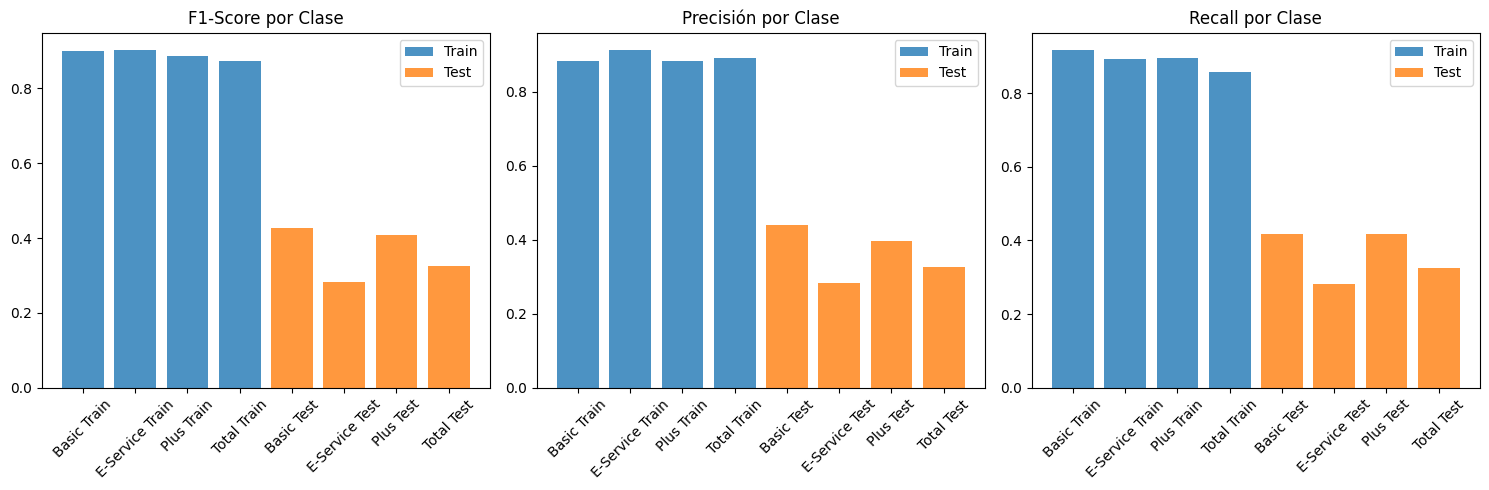


Análisis de Overfitting:
-----------------------
Accuracy en entrenamiento: 0.8912
Accuracy en test: 0.3700
Gap de overfitting: 0.5212


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Cargar el modelo guardado y los datos
model_data = joblib.load('advanced_model.joblib')
best_params = model_data['best_params']

# Cargar datos
df = pd.read_csv('telecust1000_transformed.csv')

# Preparar datos
features = ['income_log', 'age_scaled', 'tenure_scaled', 'employ_scaled', 
           'retire_scaled', 'region', 'marital', 'ed', 'gender', 'reside']

X = df[features]
y = df['custcat']

# Convertir variables categóricas
X = pd.get_dummies(X, columns=['region', 'marital', 'ed', 'gender', 'reside'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear pipeline con los mejores parámetros
model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(**best_params, random_state=42))
])

# Generar curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# Calcular medias y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='o')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')

plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves - Gradient Boosting con SMOTE')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Entrenar modelo y obtener predicciones
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calcular scores por clase para train y test
from sklearn.metrics import precision_recall_fscore_support

train_metrics = precision_recall_fscore_support(y_train, train_pred, average=None)
test_metrics = precision_recall_fscore_support(y_test, test_pred, average=None)

# Crear DataFrame con métricas por clase
metrics_df = pd.DataFrame({
    'Class': ['Basic', 'E-Service', 'Plus', 'Total'],
    'Train_Precision': train_metrics[0],
    'Test_Precision': test_metrics[0],
    'Train_Recall': train_metrics[1],
    'Test_Recall': test_metrics[1],
    'Train_F1': train_metrics[2],
    'Test_F1': test_metrics[2]
})

# Visualizar diferencias entre train y test por clase
plt.figure(figsize=(15, 5))

# F1-Score por clase
plt.subplot(1, 3, 1)
plt.bar(metrics_df['Class'] + ' Train', metrics_df['Train_F1'], label='Train', alpha=0.8)
plt.bar(metrics_df['Class'] + ' Test', metrics_df['Test_F1'], label='Test', alpha=0.8)
plt.title('F1-Score por Clase')
plt.xticks(rotation=45)
plt.legend()

# Precision por clase
plt.subplot(1, 3, 2)
plt.bar(metrics_df['Class'] + ' Train', metrics_df['Train_Precision'], label='Train', alpha=0.8)
plt.bar(metrics_df['Class'] + ' Test', metrics_df['Test_Precision'], label='Test', alpha=0.8)
plt.title('Precisión por Clase')
plt.xticks(rotation=45)
plt.legend()

# Recall por clase
plt.subplot(1, 3, 3)
plt.bar(metrics_df['Class'] + ' Train', metrics_df['Train_Recall'], label='Train', alpha=0.8)
plt.bar(metrics_df['Class'] + ' Test', metrics_df['Test_Recall'], label='Test', alpha=0.8)
plt.title('Recall por Clase')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Calcular y mostrar el gap de overfitting
print("\nAnálisis de Overfitting:")
print("-----------------------")
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
overfitting_gap = train_accuracy - test_accuracy

print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy en test: {test_accuracy:.4f}")
print(f"Gap de overfitting: {overfitting_gap:.4f}")

# Guardar análisis en archivo
with open('overfitting_analysis.txt', 'w') as f:
    f.write("ANÁLISIS DE OVERFITTING\n")
    f.write("=====================\n\n")
    f.write(f"Accuracy en entrenamiento: {train_accuracy:.4f}\n")
    f.write(f"Accuracy en test: {test_accuracy:.4f}\n")
    f.write(f"Gap de overfitting: {overfitting_gap:.4f}\n\n")
    
    f.write("Métricas por clase:\n")
    f.write(metrics_df.to_string())